In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_paths.nsd_path

''

#### Load fit results

In [3]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]
fitting_type2 = 'gabor_solo_ridge_12ori_8sf_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type2, n_from_end=0, \
                                  verbose=False)  for ss in subjects]

# create ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

#### Process results of permutation test, compute p-values

In [4]:
from utils import stats_utils
from plotting import summary_plots

p_voxels_orig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real_orig = out[si]['val_r2']
    r2_shuff_orig = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p_orig = np.mean(r2_real_orig[:,0,None]<=r2_shuff_orig[:,0,:], axis=1)
    _,pvals_fdr_orig = stats_utils.fdr_keepshape(p_orig, alpha=0.01, \
                                                   method='poscorr')
    p_voxels_orig[si] = pvals_fdr_orig
    
# thresholding voxels based on the permutation test
p = np.concatenate(p_voxels_orig, axis=0)
abv_thresh = p<0.01


#### Get info about the Gabor feature space

In [5]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [6]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)

# find maxes for orient/SF
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
assert(not(np.any(is_constant)))

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
assert(not(np.any(is_constant)))


#### Histograms of preferred features

In [7]:
n_vox = preferred_ori_corr.shape[0]
feature_prefs_2dhist = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr[vv])
    ff = int(preferred_sf_corr[vv])
    feature_prefs_2dhist[vv,oo,ff] = 1

#### Now compute ROI-averaged response profiles
For each participant separately

In [8]:
avg_resp_profiles = np.zeros((n_subjects, n_rois, n_ori, n_sf))
for si in range(n_subjects):
    for ri in range(n_rois):        
        inds_this_roi = roi_def.get_indices(ri) & abv_thresh & (subject_inds==si)   
      
        avg_resp_profiles[si,ri,:,:] = np.mean(allcorr_reshaped[inds_this_roi,:,:], axis=0)

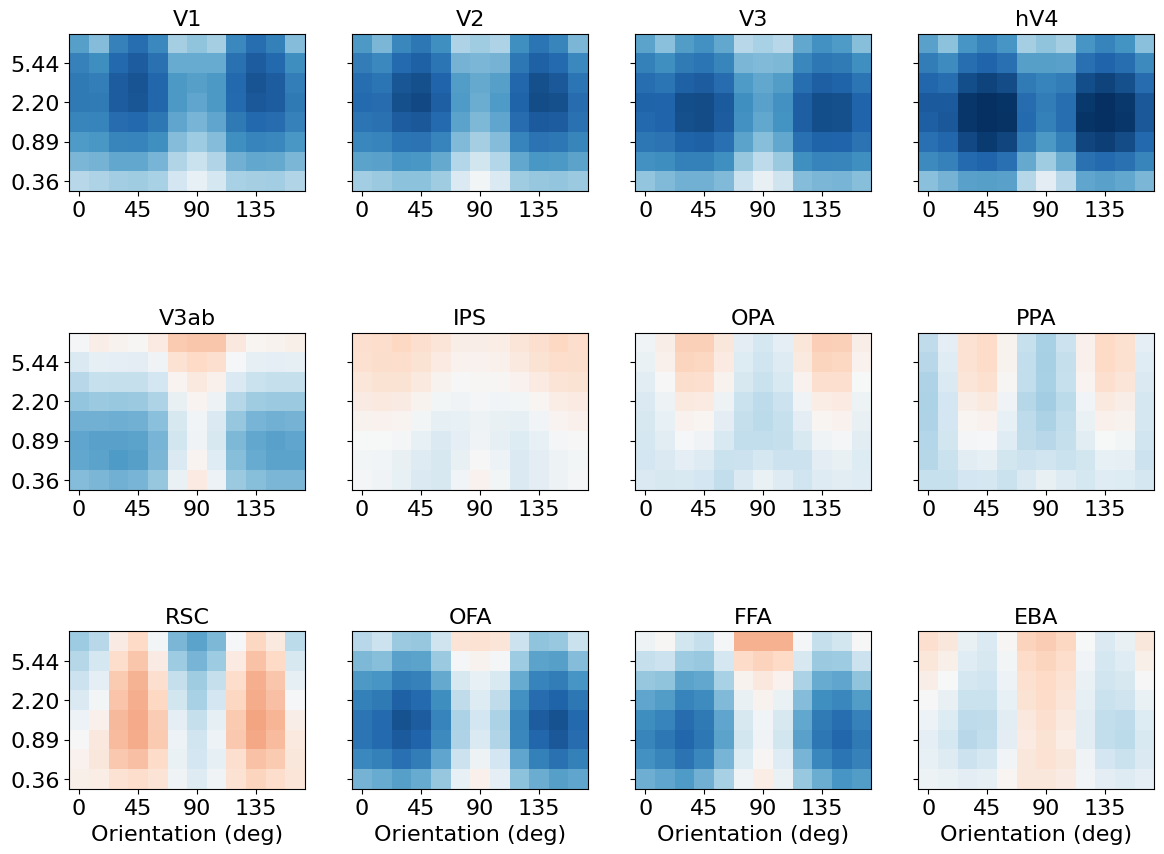

In [9]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,11))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

colors = cm.viridis(np.linspace(0,1,n_sf+1))[0:-1,:]

pi=0

clims = [-0.6, 0.6]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=0)
    
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr,4)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        if rr==6:
            plt.ylabel('S.F. (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
    # plt.axis('off')
    
    # plt.colorbar()

    if rr>7:
        plt.xlabel('Orientation (deg)')
   
    plt.title('%s'%(roi_names[rr]))
fn2save = os.path.join(default_paths.fig_path, 'Feature_sensitivity_2d_allareas.pdf')
# plt.savefig(fn2save)

['OFA' 'FFA']
['OPA' 'PPA' 'RSC']


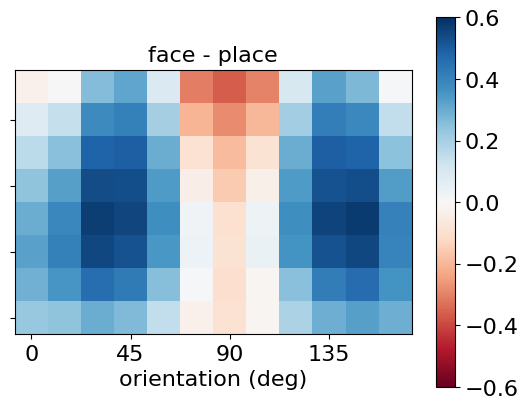

In [10]:
rinds1 = np.array([9,10])
rinds2 = np.array([6,7,8])
print(np.array(roi_names)[rinds1])
print(np.array(roi_names)[rinds2])
      
vals1 = np.mean(np.mean(avg_resp_profiles[:,rinds1,:,:], axis=0), axis=0)
vals2 = np.mean(np.mean(avg_resp_profiles[:,rinds2,:,:], axis=0), axis=0)

vals = vals1 - vals2

clims = [-0.6, 0.6]
plt.figure()
plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
sf_ticks = sf_unique[[0,2,4,6]].round(2)
if np.mod(rr,4)==0:
    plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
    plt.ylabel('spatial frequency (cyc/deg)')
else:
    plt.yticks(np.array([0,2,4,6])+0.5,[])
plt.axis('square')
plt.xlim([0,12])
plt.ylim([0,8])
# plt.axis('off')
plt.colorbar()

plt.xlabel('orientation (deg)')

plt.title('face - place')

fn2save = os.path.join(default_paths.fig_path, '2d_profile_face-place.pdf')
plt.savefig(fn2save)

['OFA' 'FFA']
['OPA' 'PPA' 'RSC']


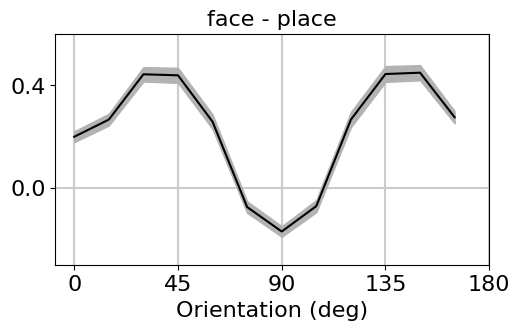

In [10]:
rinds1 = np.array([9,10])
rinds2 = np.array([6,7,8])
print(np.array(roi_names)[rinds1])
print(np.array(roi_names)[rinds2])
    
vals1 = np.mean(np.mean(avg_resp_profiles[:,rinds1,:,:], axis=1), axis=2)
vals2 = np.mean(np.mean(avg_resp_profiles[:,rinds2,:,:], axis=1), axis=2)
   
vals = vals1 - vals2

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

plt.figure(figsize=(5.6,3))

ylims = [-0.3, 0.6]
yticks = [0, 0.4]

plt.plot(ori_unique,  meanvals, '-',color='k')
plt.fill_between(ori_unique, meanvals-semvals, meanvals+semvals, alpha=1, color=[0.7, 0.7, 0.7])
plt.axhline(0, color=[0.8, 0.8, 0.8],zorder=-10)
plt.ylim(ylims)
plt.yticks(yticks)
plt.xlabel('Orientation (deg)')
plt.xticks(np.arange(0,181,45))

for ii in np.arange(0,181,45):
    plt.axvline(ii,color=[0.8, 0.8, 0.8],zorder=-10)

plt.title('face - place')

fn2save = os.path.join(default_paths.fig_path, 'orientation_profile_face-place.pdf')
plt.savefig(fn2save)

['OFA' 'FFA']
['OPA' 'PPA' 'RSC']


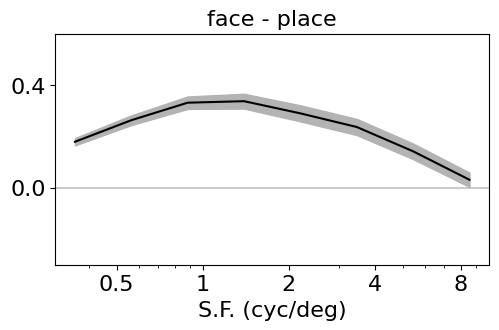

In [11]:
rinds1 = np.array([9,10])
rinds2 = np.array([6,7,8])
print(np.array(roi_names)[rinds1])
print(np.array(roi_names)[rinds2])
    
vals1 = np.mean(np.mean(avg_resp_profiles[:,rinds1,:,:], axis=1), axis=1)
vals2 = np.mean(np.mean(avg_resp_profiles[:,rinds2,:,:], axis=1), axis=1)
   
vals = vals1 - vals2

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

plt.figure(figsize=(5.6,3))

ylims = [-0.3, 0.6]
yticks = [0, 0.4]

plt.plot(sf_unique,  meanvals, '-',color='k')
plt.fill_between(sf_unique, meanvals-semvals, meanvals+semvals, alpha=1, color=[0.7, 0.7, 0.7])

plt.axhline(0, color=[0.8, 0.8, 0.8], zorder=-10)
plt.ylim(ylims)
plt.yticks(yticks)
plt.gca().set_xscale('log')
plt.xlabel('S.F. (cyc/deg)')
plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                10**np.log10(2),10**np.log10(4), \
                10**np.log10(8)],\
               [0.5,1,2,4,8])

plt.title('face - place')

fn2save = os.path.join(default_paths.fig_path, 'sf_profile_face-place.pdf')
plt.savefig(fn2save)

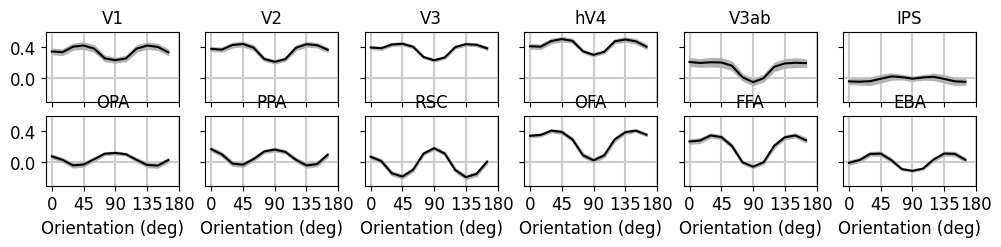

In [12]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(12,2))

rois2plot = np.arange(n_rois)
npy = int(len(rois2plot)/2)
npx = 2;
# plot_inds = []
# for rr in range(n_rois):
#     plot_inds += [rr+1]
#     plot_inds += [rr+n_rois+1]
    

ylims = [-0.3, 0.6]
yticks = [0, 0.4]

pi=0

for ri, rr in enumerate(rois2plot):
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)
    
    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=2)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(ori_unique,  meanvals, '-',color='k')
    plt.fill_between(ori_unique, meanvals-semvals, meanvals+semvals, alpha=1, color=[0.7, 0.7, 0.7])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8],zorder=-10)
    plt.ylim(ylims)
    
    if np.mod(pi,npy)==1:
        # plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    if ri>=npy:
        plt.xlabel('Orientation (deg)')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks(np.arange(0,181,45), labels=[])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8],zorder=-10)

    plt.title('%s'%(roi_names[rr]))
    
fn2save = os.path.join(default_paths.fig_path, 'Marginal_orient_profiles_allareas.pdf')
plt.savefig(fn2save)

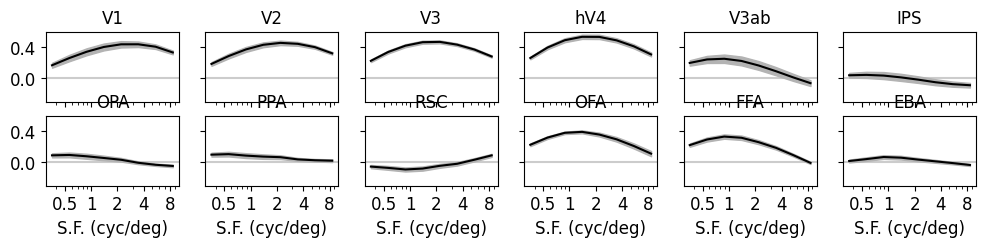

In [13]:
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(12,2))

rois2plot = np.arange(n_rois)
npy = int(len(rois2plot)/2)
npx = 2;
# plot_inds = []
# for rr in range(n_rois):
#     plot_inds += [rr+1]
#     plot_inds += [rr+n_rois+1]
    

ylims = [-0.3, 0.6]
yticks = [0, 0.4]

pi=0

for ri, rr in enumerate(rois2plot):
# for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    vals = np.mean(avg_resp_profiles[:,rr,:,:], axis=1)
    meanvals = np.mean(vals, axis=0)
    semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)
    
    plt.plot(sf_unique,  meanvals, '-',color='k')
    plt.fill_between(sf_unique, meanvals-semvals, meanvals+semvals, alpha=1, color=[0.7, 0.7, 0.7])
    
    plt.axhline(0, color=[0.8, 0.8, 0.8], zorder=-10)
    plt.ylim(ylims)
    
    if np.mod(pi,npy)==1:
        # plt.ylabel('corr coef')
        plt.yticks(yticks)
    else:
        plt.yticks(yticks, labels=[])

    plt.gca().set_xscale('log')
    if ri>=npy:
        plt.xlabel('S.F. (cyc/deg)')
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [0.5,1,2,4,8])
    
    else:
        plt.xticks([10**np.log10(0.5), 10**np.log10(1), \
                    10**np.log10(2),10**np.log10(4), \
                    10**np.log10(8)],\
                   [])

    plt.title('%s'%(roi_names[rr]))

fn2save = os.path.join(default_paths.fig_path, 'Marginal_freq_profiles_allareas.pdf')
plt.savefig(fn2save)

#### This is Supplementary Figure 2
Tuning histograms in 2D

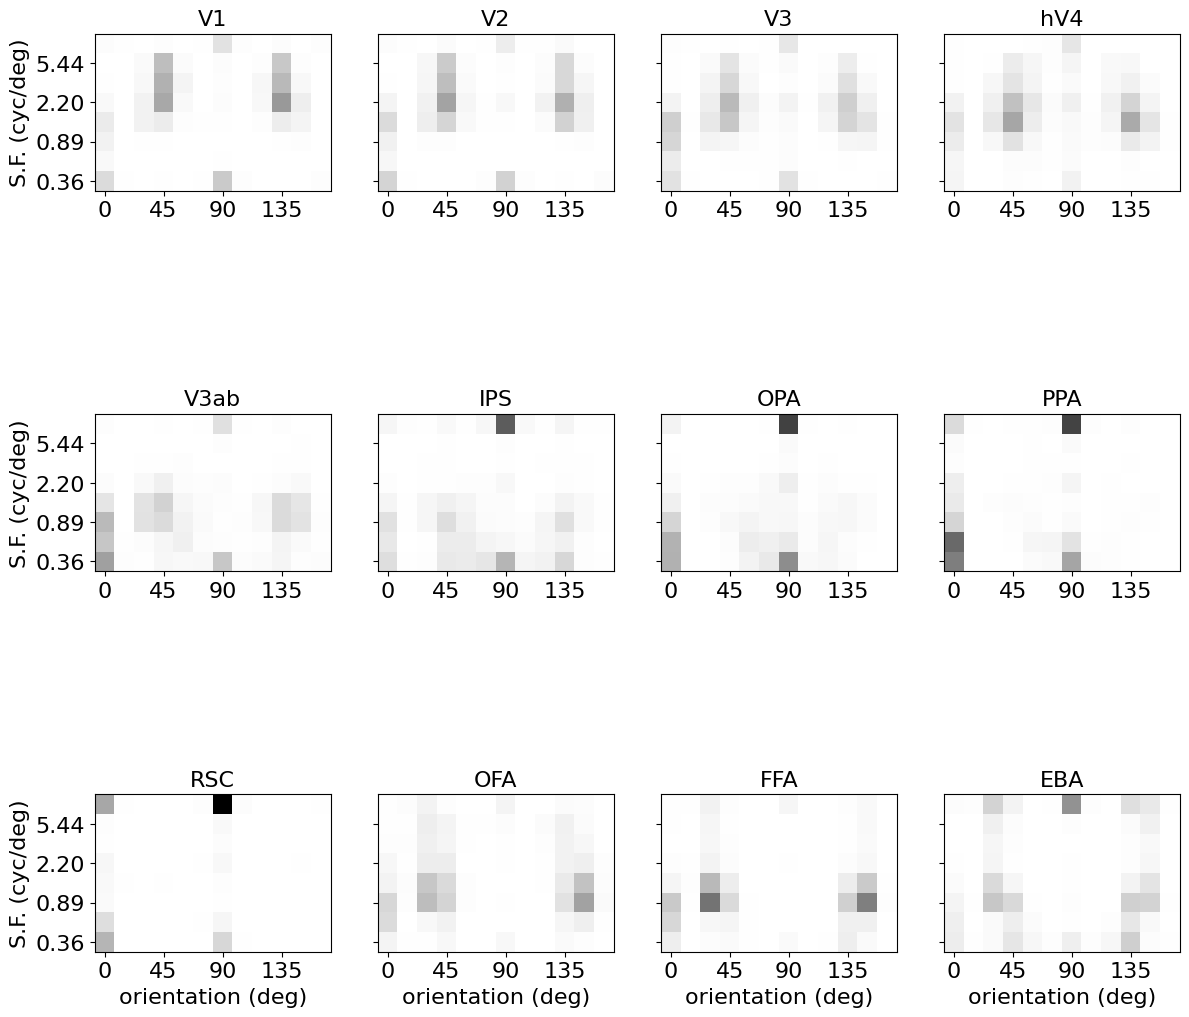

In [18]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(14,14))
npx = 3;npy = 4;
# npy = int(np.ceil(np.sqrt(n_rois)))
# npx = int(np.ceil((n_rois)/npx))

pi=0

clims = [0, 0.30]

for rr in range(n_rois):
    
    pi+=1
    plt.subplot(npx,npy,pi)

    inds_this_roi = roi_def.get_indices(rr)
    inds_this_roi = inds_this_roi & abv_thresh 
    
    vals = np.mean(feature_prefs_2dhist[inds_this_roi,:,:], axis=0)
 
    plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

    plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
    sf_ticks = sf_unique[[0,2,4,6]].round(2)
    if np.mod(rr, npy)==0:
        plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
        if np.mod(rr,4)==0:
            plt.ylabel('S.F. (cyc/deg)')
    else:
        plt.yticks(np.array([0,2,4,6])+0.5,[])
    plt.axis('square')
    plt.xlim([0,12])
    plt.ylim([0,8])
   
    if rr>7:
        plt.xlabel('orientation (deg)')
    plt.title(roi_names[rr])

fn2save = os.path.join(default_paths.fig_path, 'Selectivity_2dhist_allareas.pdf')
plt.savefig(fn2save)

#### Make Supplementary Figure 7

Compute radial bias: first gather our pRF pars

In [19]:
prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)
x = prf_pars[:,0]
y = prf_pars[:,1]

screen_eccen_deg = 8.4
angle_fwrf, eccen_fwrf = prf_utils.cart_to_pol(x*screen_eccen_deg,y*screen_eccen_deg)
sigma = prf_pars[:,2]
size_fwrf = sigma * screen_eccen_deg

In [20]:
np.max(eccen_fwrf)

6.9999995

In [21]:
np.max(size_fwrf)

8.4

#### Now make a plot of the correlation bw polar angle pref and orient pref

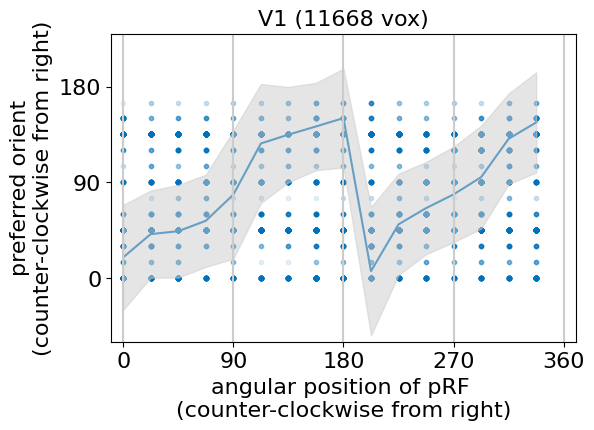

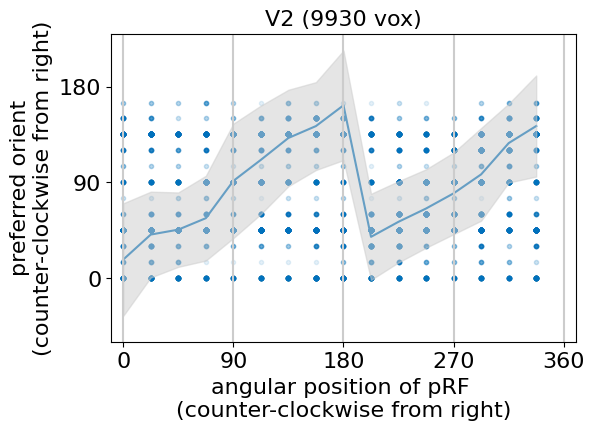

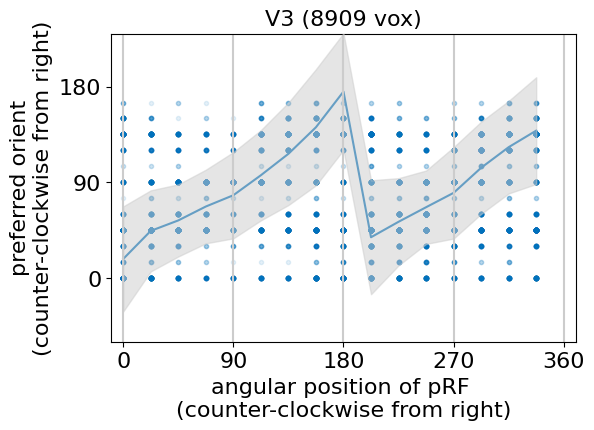

In [22]:
color = '#0071bc'
plt.rcParams['pdf.fonttype']=42

for vv in [0,1,2]:

    vinds = roi_def.get_indices(vv) & abv_thresh

    plt.figure(figsize=(6,4))

    xvals = np.round(angle_fwrf[vinds],1)
    unique_angles, counts = np.unique(xvals, return_counts=True)

    # change the coordinate system of orientation here, so that it matches with 
    # the angular positions (go counter-clockwise from right)
    yvals = np.mod(90 - ori_unique[preferred_ori_corr[vinds].astype(int)], 180)  
    # yvals = np.mod(90 - ori_unique[preferred_ori_weights[vinds].astype(int)], 180)  
    yvals_adj = yvals/180*2*np.pi # for circmean/circstd, need range 0-2pi

    ymean = np.array([scipy.stats.circmean(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)
    ystd = np.array([scipy.stats.circstd(yvals_adj[xvals==aa]) for aa in unique_angles])*180/(2*np.pi)

    plt.plot(xvals, yvals,'.',color=color, alpha=0.10)

    # plt.errorbar(unique_angles, ymean, ystd, color='k',zorder=10)
    plt.plot(unique_angles, ymean,'-',color=color)
    plt.fill_between(unique_angles, ymean+ystd, ymean-ystd, color=[0.8, 0.8, 0.8] ,alpha=0.5, zorder=10)

    for ii in np.arange(0,370,90):
        plt.axvline(ii, color=[0.8, 0.8, 0.8])

    plt.xticks(np.arange(0,370,90));
    plt.yticks(np.arange(0,190,90));
    plt.xlabel('angular position of pRF \n(counter-clockwise from right)')
    plt.ylabel('preferred orient\n(counter-clockwise from right)')

    plt.xlim([-10, 370])
    plt.ylim([-60, 230])

    plt.title('%s (%d vox)'%(roi_names[vv],np.sum(vinds)))

    fn2save = os.path.join(default_paths.fig_path, '%s_radial_bias.pdf'%roi_names[vv])
    plt.savefig(fn2save)

#### Now making Supplementary Figure 3
Use PyCortex to make surface plots

In [23]:
from plotting import pycortex_plot_utils
volumes = {}
out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False) for ss in subjects]

mm=0;

# for si, ss in zip([0],subjects[[0]]):
    
for si, ss in enumerate(subjects):

    vox2plot = abv_thresh[subject_inds==si]
 
    
    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []
      
    vals = preferred_ori_corr[subject_inds==si].astype(int)
    vals = ori_unique[vals]
    
    names += ['S%d: pref orient.'%(ss)]
    maps += [vals]
    cmaps += ['Retinotopy_RYBCR']
    mins += [0]
    maxes += [180]
    
    vals = preferred_sf_corr[subject_inds==si].astype(int)
    vals = sf_unique[vals]
    
    names += ['S%d: pref S.F.'%(ss)]
    maps += [vals]
    cmaps += ['Blues']
    mins += [0]
    maxes += [8.6]
    
    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    

In [24]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Feature selectivity maps', \
                                                port = 14447, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:14447
Started server on port 14447
Stopping server


#### Set view and save images of flatmaps

In [14]:
# load pre-made view params from a json file
# (json files are in your pycortex database folder, under subj01/views/)

viewname='flat'
# viewname='left-tilt'
# viewname='right-tilt'
# viewname='bottom'

viewer.get_view('subj01',viewname)

# to make the view:
# viewer.save_view('subj01','flat1',True)

In [21]:
ss = 4;

fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_orient_%s_raw.png'%(ss,viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/image_stats_gabor/figures/S04_orient_flat_raw.png


[{}]

In [22]:
ss = 4;

fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_spatfreq_%s_raw.png'%(ss,viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/image_stats_gabor/figures/S04_spatfreq_flat_raw.png


[{}]

In [23]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [26]:
import PIL
for ss in [1,2,3,4]:
    
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_orient_%s_raw.png'%(ss,viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                           'S%02d_orient_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)
        
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_spatfreq_%s_raw.png'%(ss,viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                           'S%02d_spatfreq_%s_cropped.png'%(ss,viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000
3000
3000
3000
3000
3000


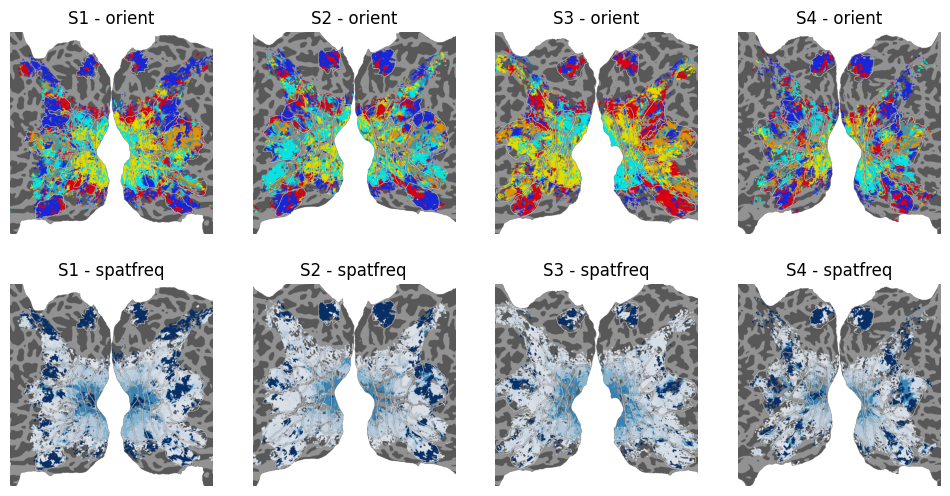

In [30]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plt.figure(figsize=(12,6))

pi=0

for ii, feat in enumerate(['orient','spatfreq']):
    
    for ss in [1,2,3,4]:
    
    
        fn2save_cropped = os.path.join(default_paths.fig_path, \
                               'S%02d_%s_%s_cropped.png'%(ss,feat,viewname))
        im = PIL.Image.open(fn2save_cropped)

        pi+=1
        plt.subplot(2,4,pi);
        plt.imshow(im)
        plt.title('S%d - %s'%(ss, feat))
        plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'feature_tuning_flatmaps.pdf')
plt.savefig(fn2save,dpi=1000)